# Introduction

Nama : Wahyudi

Dataset : First GOP Debate Twitter Sentiment

Objectif : Create a model that can classify whether a tweet has negative, neutral or positive sentiment.

I created this notebook using google colab.

In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
% cd /content/drive/MyDrive/data science/Tugas/milestone 2

/content/drive/MyDrive/data science/Tugas/milestone 2


# Import Libraries

The first thing to do is import the required libraries

In [85]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from PIL import Image
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from keras.callbacks import ModelCheckpoint, CSVLogger
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, TextVectorization, GRU
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

We need to download some data from NLTK

In [76]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words=nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Data Loading

This data i got from Kaggle. [link disini](https://www.kaggle.com/datasets/crowdflower/first-gop-debate-twitter-sentiment/code?select=Sentiment.csv)

In [77]:
data=pd.read_csv('Sentiment.csv')

In [78]:
data

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0000,yes,1.0000,Neutral,0.6578,None of the above,1.0000,NaN,...,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
1,2,Scott Walker,1.0000,yes,1.0000,Positive,0.6333,None of the above,1.0000,NaN,...,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
2,3,No candidate mentioned,1.0000,yes,1.0000,Neutral,0.6629,None of the above,0.6629,NaN,...,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
3,4,No candidate mentioned,1.0000,yes,1.0000,Positive,1.0000,None of the above,0.7039,NaN,...,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0000,yes,1.0000,Positive,0.7045,None of the above,1.0000,NaN,...,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13866,13867,No candidate mentioned,1.0000,yes,1.0000,Negative,0.7991,Abortion,0.6014,No candidate mentioned,...,yes,7,Negative,Abortion\nWomen's Issues (not abortion though),RT @cappy_yarbrough: Love to see men who will ...,NaN,2015-08-07 09:29:43 -0700,629690895479250944,Como,NaN
13867,13868,Mike Huckabee,0.9611,yes,1.0000,Positive,0.7302,None of the above,0.9229,Mike Huckabee,...,yes,1,NaN,NaN,RT @georgehenryw: Who thought Huckabee exceede...,NaN,2015-08-07 09:25:02 -0700,629689719056568320,USA,NaN
13868,13869,Ted Cruz,1.0000,yes,1.0000,Positive,0.8051,None of the above,0.9647,Ted Cruz,...,yes,67,Positive\nNeutral,NaN,"RT @Lrihendry: #TedCruz As President, I will a...",NaN,2015-08-07 07:19:18 -0700,629658075784282112,NaN,NaN
13869,13870,Donald Trump,1.0000,yes,1.0000,Negative,1.0000,Women's Issues (not abortion though),0.9202,Donald Trump,...,yes,149,NaN,Women's Issues (not abortion though),RT @JRehling: #GOPDebate Donald Trump says tha...,NaN,2015-08-07 09:54:04 -0700,629697023663546368,NaN,NaN


The data consists of 13,871 rows and 21 features. Because in this case it is a classification case I will not use all the features. The main features that will be used are the `text` feature and the `sentiment` feature

The features I chose to research were `text`, `candidate`, `sentiment`. I chose these features because it would be interesting to be able to display sentiment analysis based on the candidates.

In [79]:
data=data[['text','candidate','sentiment']]

# Exploratory Data Analysis

In [80]:
# copy data for EDA
data_eda=data.copy()

## Sentimen

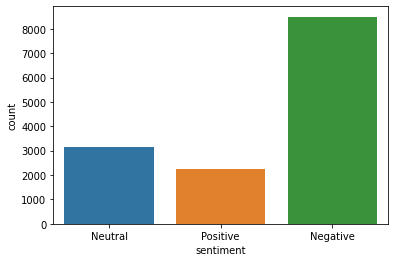

In [10]:
#Show how many tweet by sentiment
sns.countplot(data=data_eda, x = 'sentiment');

The most common sentiment in the data set is negative sentiment. And it is very unfortunate because positive sentiment is the least sentiment, even less than neutral sentiment. Target data is imbalanced data because it has quite a different number of targets for each category. An imbalanced target will effect the model results

### Sentiment by candidate

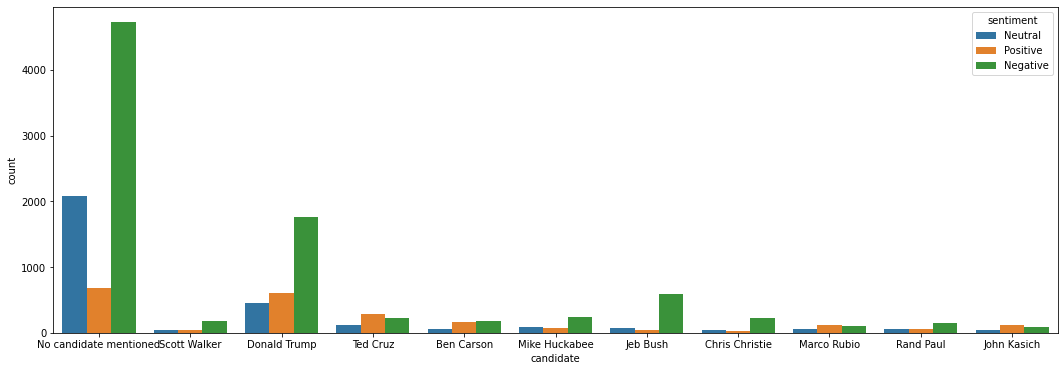

In [ ]:
#figure how many tweet by candidate & sentiment
fig, ax= plt.subplots(figsize=[18,6])
sns.countplot(data=data_eda, hue = 'sentiment', x='candidate', ax=ax);

Almost all candidates have higher negative sentiment than other sentiments. Except for candidates **ted cruz**, **marco rubio**, and **john kasich**. These three candidates have more neutral sentiment than negative sentiment. However, none of the candidates has positive sentiment as the majority sentiment.

Donald Trump is the candidate with the highest popularity on Twitter. However, unfortunately most of the tweets related to Donald Trump are tweets with negative sentiments.

### Sentiment by lenght word

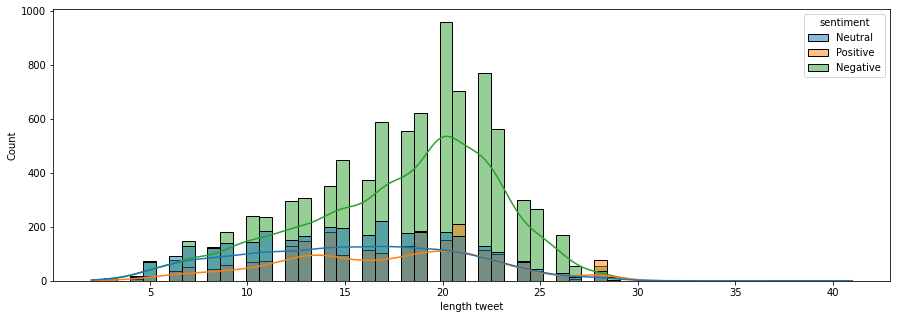

In [ ]:
data_eda['length tweet']=data_eda['text'].str.count(' ') + 1
fig, ax=plt.subplots(figsize=[15,5])
sns.histplot(data=data_eda, x = 'length tweet', hue='sentiment', kde=True, ax=ax)

All sentiments have the same long-term characteristics. The maximum number of words is 41. It has become a characteristic of Twitter users that their tweets don't have too many words. This is because Twitter limits its users to around 180 characters in 1 tweet. Most tweeters tweet about 20 words. I think 20 words can be 2-3 sentences. And it is very rare for Twitter users to tweet more than 28 words. However, in tweets with more words, there tends to be more positive sentiment.

## Populer Word

Because the dataset is tweet data, I added `rt` and `re` as stop words. These two words mean retweet and replay.

In [81]:
stop_words+=['rt', 're']

I also deleted words starting with @ and links as well as the # sign and internet links. Links are usually identified by the characteristic words starting with `www`, `http`, `https`. I will also delete the stop words so that I can see the characters of each target more clearly

In [12]:
def preprocessing_text(texts):
  texts = texts.lower() #make it lowercase
  texts = re.sub("@[a-z0-9_.]+"," ", texts) # Remove words starting with @
  texts = re.sub(r"http\S+", " ", texts) #remove link
  texts = re.sub(r"https\S+", " ", texts) #remove link
  texts = re.sub(r"www.\S+", " ", texts) #remove link
  tokens = word_tokenize(texts) # tokeenize
  texts = ' '.join([word for word in tokens if word not in stop_words]) #remove stop word
  texts = re.sub(r"#", "", texts)
  return texts

In [13]:
data_eda['text clean']=data_eda['text'].apply(lambda x: preprocessing_text(x)) #cleaning word process

In [14]:
vectorize=TfidfVectorizer() #TFIDF initializer

Before using the word cloud, I first carried out tf-idf data with the hope that the words that appeared were only important words.

In [17]:
# create a function to create a word cloud via tf idf.
def plot_word(data, color = 'black', figsize=(15, 10), max_words=75):
    teks=vectorize.fit_transform(data)
    feature_names = vectorize.get_feature_names()
    dense = teks.todense()
    lst1 = dense.tolist()
    df = pd.DataFrame(lst1, columns=feature_names)
    wordcloud = WordCloud(stopwords=stop_words, # delete stopword
                      background_color=color,
                      width=1200,
                      height=800,
                      max_words=max_words,
                     ).generate_from_frequencies(df.T.sum(axis=1))
    plt.figure(1,figsize=figsize)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

### Positive Sentimen

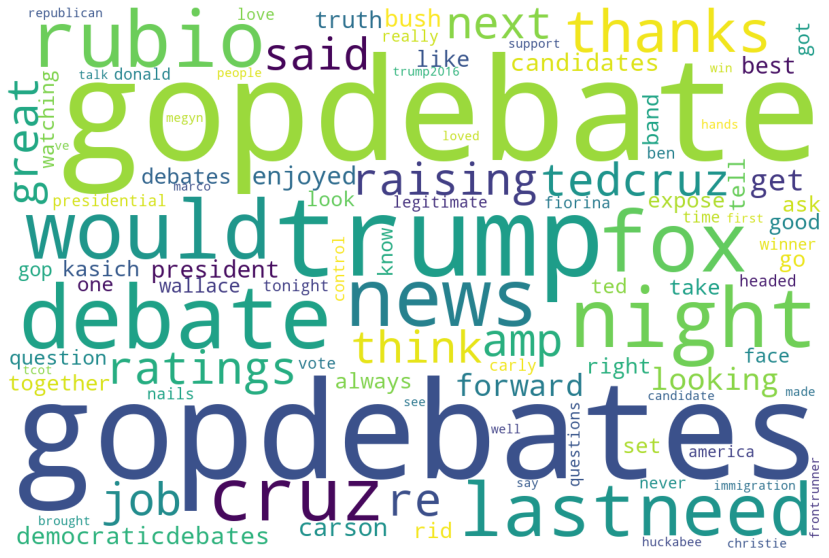

In [ ]:
#show wordcloud sentimen positif
plot_word(data_eda[data_eda.sentiment=="Positive"]['text clean'], 'white', max_words=100)

In positive sentiment we can see that there are several words with positive sentiment such as the words next, forward, great, job, raising etc. Apart from words that have positive connotations. Data on positive sentiment is also filled with words that are directly related to the debate agenda of the republican party, such as gopdebat, debate, and the names of candidates from the republican party.

### Negative Sentimen

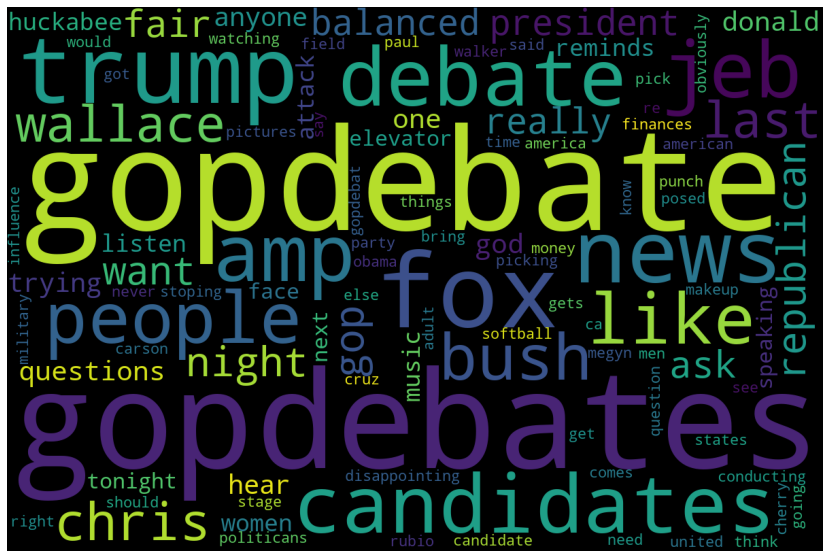

In [ ]:
#show wordcloud sentimen negatif
plot_word(data_eda[data_eda.sentiment=="Negative"]['text clean'], max_words=100)

The negative sentiment data is filled with too many words that are directly related to the event, so it is not really easy to read what words appear and have negative sentiment. I will try to add the candidate's name and various words that are directly related to the debate agenda as stop words so that the characteristics of words with negative sentiment are more visible in the data.

In [82]:
candidate=data[(data['candidate']!='No candidate mentioned')&~(data['candidate'].isnull())]['candidate'].unique()
for cdt in candidate:
  stop_words+=cdt.lower().split()
event_word=['gopdebates', 'gopdebate','gop','debate', 'debates']
stop_words+=event_word
data_eda['text clean']=data_eda['text'].apply(lambda x: preprocessing_text(x))

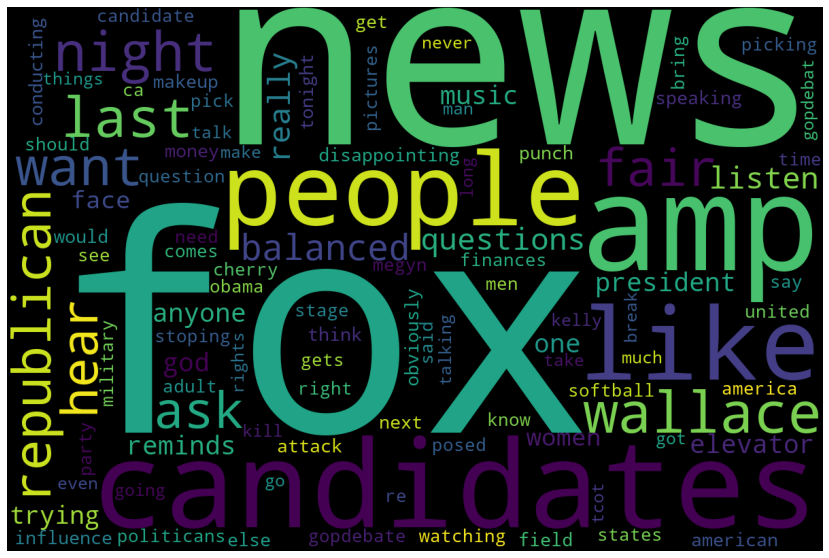

In [18]:
#show wordcloud sentimen negatif
plot_word(data_eda[data_eda.sentiment=="Negative"]['text clean'], max_words=100)

It doesn't seem like there are too many words that really have a negative connotation. There are only a few words that are very likely to have a negative connotation, such as 'kill, military, stopping, disppointing'. Most of the vocab displayed are common words such as want, banace, etc.

### Neutral Sentimen

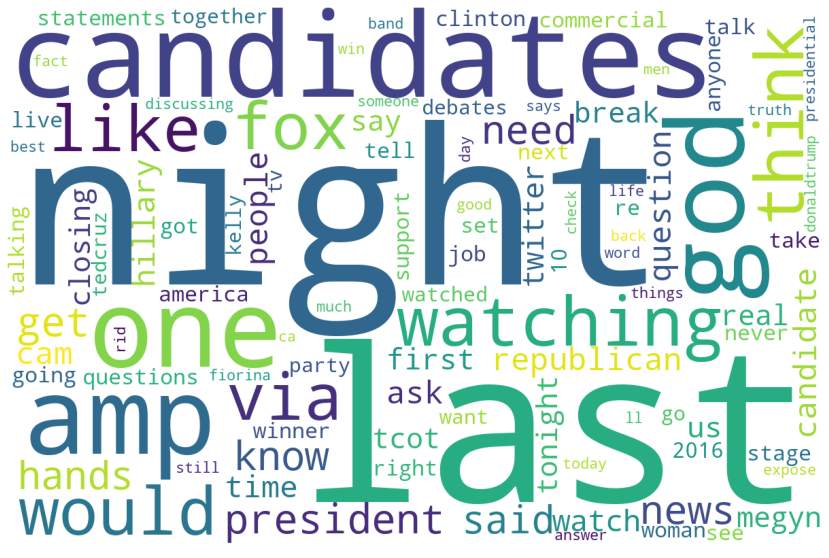

In [ ]:
plot_word(data_eda[data_eda.sentiment=="Neutral"]['text clean'], 'white', max_words=100)

Meanwhile, in neutral sentiment, almost all the words that appear do not have any connotation. Like the words, president, night, watch, last and so on.

# Preprocessing

## Get Inference

create inference data

In [83]:
data_inf = data.sample(10, random_state=0)
data= data.drop(data_inf.index)

## Case Folding

There are several special characteristics that this dataset has. Because the data is data taken from Twitter data, the text data needs to be cleaned from the use of the `@` sign because the word refers to a username which I judge does not contain any sentiment. Likewise with the word rt which is usually used as a sign of retweet. I will also delete the words that are links because I consider links to have no sentiment.

In contrast to hashtags, hashtags are usually used on Twitter as a form of promoting an idea or feeling. I think hashtags will be an important feature for models.

Apart from all that, case folding also needs to be done, starting from lowering the text. Change all words to lower case to reduce the number of word variations, so that the word `Evil` is considered the same as `evil`. To reduce vocab variations as well, I will lemitize the text data, that is, returning each word to its base word. I did this because this data set is in English, so that words with different verbs will be unified into the basic word.

Apart from deleting words related to Twitter, I also need to delete various words that often appear but do not have any connotation, such as the names of candidates, gop, gop debate and so on which I have added to the stop words in EDA.

In [84]:
max_feature=0
#create a function for case folding
def preprocessing_text(texts):
  global max_feature
  lemmatizer = WordNetLemmatizer()
  texts = texts.lower() #lowering text
  texts = texts.strip()
  texts = re.sub("@[a-z0-9_.]+"," ", texts) # Remove words starting with @
  texts = re.sub(r"\\n"," ",texts) #remove the enter text
  texts = re.sub(r"http\S+", " ", texts) #remove link
  texts = re.sub(r"www.\S+", " ", texts) #remove link
  texts = re.sub("[^a-z\s']"," ", texts) # remove selain alfabet
  tokens = word_tokenize(texts) # tokeenize
  if len(tokens)>max_feature:max_feature=len(tokens) # count the words with the highest number of words.
  texts=lemmatizer.lemmatize(texts) #lematizing
  texts = ' '.join([word for word in tokens if word not in stop_words]) #remove stop word
  return texts

case folding data process...

In [86]:
data['feature']=data['text'].apply(lambda x: preprocessing_text(x))

Target data needs to be converted into numbers so that it can be recognized by `to categorical`

In [87]:
data['label'] = data['sentiment'].replace({'Negative' : 0, 'Neutral' : 1, 'Positive' : 2})

## Split Data set

The data is converted into 3 parts, namely train data and validation data which will be used to train the model and test data which will be used to evaluate the model.

In [88]:
X_train, X_test, y_train, y_test = train_test_split(data.feature, data.label, test_size=0.2, random_state=46, stratify=data.label)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=46)

## Encoding Target

In [89]:
y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)
y_val_ohe = to_categorical(y_val)

## Text Vectorizing

Counting the number of vocab...

In [90]:
#Hitung jumlah cocab
Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
jml_vocab = len(Vectorize.vocabulary_.keys())
print('jumlah vocab adalah sebanyak '+str(jml_vocab))

jumlah vocab adalah sebanyak 9130


# Intializing Model

The models used are 2 types, namely models with LSTM layers and models using GRU layers. Both models are preferred over RNN because the maximum document length is 32 and it is not suitable to use RNN because RNN has the limitation of being able to work optimally on sequence data of up to 10 rows of data.

The first model created is the base model, namely the model with default parameters, both in the LSTM and GRU models.

Text vectorization needs to be adapted at the beginning

In [91]:
text_vectorization = TextVectorization(max_tokens=jml_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_feature,
                                       input_shape=(1,)
                                       )

text_vectorization.adapt(X_train)

## LSTM Model

In [31]:
embedding = Embedding(input_dim=jml_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=jml_vocab
                      )
model_lstm_1st = Sequential()
model_lstm_1st.add(text_vectorization)
model_lstm_1st.add(embedding)
model_lstm_1st.add(LSTM(max_feature))
model_lstm_1st.add(Dense(3,activation='softmax'))

model_lstm_1st.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model_lstm_1st.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 32)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 32, 128)           1160448   
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 1,181,155
Trainable params: 1,181,155
Non-trainable params: 0
_________________________________________________________________
None


The model consists of 2 preprocessing layers, namely text vectorizing and embeding, 1 LSTM layer and 1 output layer with `softmax` activation. Because this model is intended for classification, the loss I use is `categorical_crossentropy` and the metric used is the `accuracy` metric. Accuracy was chosen because in this modeling, we are not focusing on one target.

The `GRU` model is also created the same as the LSTM model.

## GRU Model

In [31]:
embedding = Embedding(input_dim=jml_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=jml_vocab
                      )
model_gru_1st = Sequential()
model_gru_1st.add(text_vectorization)
model_gru_1st.add(embedding)
model_gru_1st.add(GRU(max_feature))
model_gru_1st.add(Dense(3,activation='softmax'))
model_gru_1st.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model_gru_1st.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 32)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 32, 128)           1168640   
                                                                 
 gru (GRU)                   (None, 32)                15552     
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 1,184,291
Trainable params: 1,184,291
Non-trainable params: 0
_________________________________________________________________
None


# Train Model

## LSTM Model

In [33]:
csv_logger = CSVLogger('hist_lstm_1st.log')
model_checkpoint_callback = ModelCheckpoint(
    filepath='model/lstm_1st',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

hist_lstm_1st = model_lstm_1st.fit(X_train,
                         y_train_ohe,
                         epochs=50,
                         batch_size=16,
                         callbacks=[csv_logger, model_checkpoint_callback],
                         validation_data=(X_test, y_test_ohe))

Epoch 1/50
551/551 [==============================] - 24s 39ms/step - loss: 0.8896 - accuracy: 0.6167 - val_loss: 0.8249 - val_accuracy: 0.6342
Epoch 2/50
551/551 [==============================] - 17s 31ms/step - loss: 0.7142 - accuracy: 0.6906 - val_loss: 0.8040 - val_accuracy: 0.6622
Epoch 3/50
551/551 [==============================] - 22s 39ms/step - loss: 0.5932 - accuracy: 0.7568 - val_loss: 0.8704 - val_accuracy: 0.6429
Epoch 4/50
551/551 [==============================] - 23s 42ms/step - loss: 0.5223 - accuracy: 0.7939 - val_loss: 0.9073 - val_accuracy: 0.6582
Epoch 5/50
551/551 [==============================] - 20s 36ms/step - loss: 0.4615 - accuracy: 0.8238 - val_loss: 0.9747 - val_accuracy: 0.6564
Epoch 6/50
551/551 [==============================] - 18s 32ms/step - loss: 0.4091 - accuracy: 0.8535 - val_loss: 0.9595 - val_accuracy: 0.6538
Epoch 7/50
551/551 [==============================] - 27s 49ms/step - loss: 0.3707 - accuracy: 0.8675 - val_loss: 1.0910 - val_accuracy:

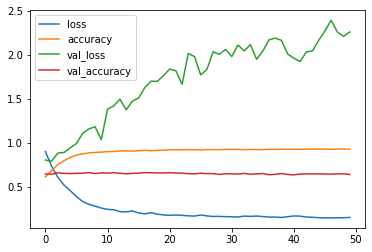

In [ ]:
metrics = pd.DataFrame(hist_lstm_1st.history)
metrics.plot()

From the graph above, the model is indicated as an **overfit** model. `Loss` in the model continues to decrease, but in the validation data `croos entrophy` continues to increase. Likewise, the `accuracy' metric has increased, but the valuation data is only stagnant at around 60% accuracy.

## GRU Model

In [32]:
csv_logger = CSVLogger('hist_gru_1st.log')
model_checkpoint_callback = ModelCheckpoint(
    filepath='model/gru_1st',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

hist_gru_1st = model_gru_1st.fit(X_train,
                         y_train_ohe,
                         epochs=50,
                         batch_size=16,
                         callbacks=[csv_logger, model_checkpoint_callback],
                         validation_data=(X_test, y_test_ohe))

Epoch 1/50
555/555 [==============================] - 11s 9ms/step - loss: 0.9260 - accuracy: 0.6134 - val_loss: 0.8486 - val_accuracy: 0.6167
Epoch 2/50
555/555 [==============================] - 4s 7ms/step - loss: 0.7823 - accuracy: 0.6467 - val_loss: 0.7950 - val_accuracy: 0.6513
Epoch 3/50
555/555 [==============================] - 4s 8ms/step - loss: 0.6034 - accuracy: 0.7430 - val_loss: 0.8471 - val_accuracy: 0.6286
Epoch 4/50
555/555 [==============================] - 4s 7ms/step - loss: 0.4528 - accuracy: 0.8240 - val_loss: 0.8957 - val_accuracy: 0.6311
Epoch 5/50
555/555 [==============================] - 4s 7ms/step - loss: 0.3496 - accuracy: 0.8685 - val_loss: 0.9742 - val_accuracy: 0.6610
Epoch 6/50
555/555 [==============================] - 4s 8ms/step - loss: 0.2844 - accuracy: 0.8939 - val_loss: 1.0116 - val_accuracy: 0.6437
Epoch 7/50
555/555 [==============================] - 4s 6ms/step - loss: 0.2494 - accuracy: 0.9037 - val_loss: 1.0541 - val_accuracy: 0.6506
Epoch

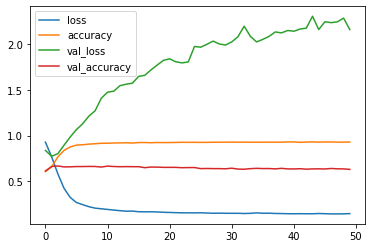

In [ ]:
pd.DataFrame(hist_gru_1st.history).plot()

Likewise with the LSTM model, the GRU model also experiences **overfit**.

# Model Evaluation

## LSTM

In [ ]:
pred_train=model_lstm_1st.predict(X_train)
pred_test=model_lstm_1st.predict(X_test)
pred_train_lbl=pred_train.argmax(axis=1)
pred_test_lbl=pred_test.argmax(axis=1)

In [ ]:
print(classification_report(y_train, pred_train_lbl))
print(classification_report(y_test, pred_test_lbl))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      5357
           1       0.97      0.79      0.87      2012
           2       0.86      0.94      0.90      1443

    accuracy                           0.93      8812
   macro avg       0.92      0.90      0.91      8812
weighted avg       0.93      0.93      0.92      8812

              precision    recall  f1-score   support

           0       0.72      0.82      0.77      1687
           1       0.43      0.32      0.36       624
           2       0.51      0.43      0.47       444

    accuracy                           0.64      2755
   macro avg       0.55      0.52      0.53      2755
weighted avg       0.62      0.64      0.63      2755



## GRU

In [ ]:
pred_train=model_gru_1st.predict(X_train)
pred_test=model_gru_1st.predict(X_test)
pred_train_lbl=pred_train.argmax(axis=1)
pred_test_lbl=pred_test.argmax(axis=1)

In [ ]:
print(classification_report(y_train, pred_train_lbl))
print(classification_report(y_test, pred_test_lbl))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      5357
           1       0.90      0.89      0.89      2012
           2       0.90      0.92      0.91      1443

    accuracy                           0.93      8812
   macro avg       0.92      0.92      0.92      8812
weighted avg       0.93      0.93      0.93      8812

              precision    recall  f1-score   support

           0       0.74      0.78      0.76      1687
           1       0.41      0.37      0.39       624
           2       0.47      0.45      0.46       444

    accuracy                           0.63      2755
   macro avg       0.54      0.53      0.53      2755
weighted avg       0.62      0.63      0.62      2755



The model is an overfit model because the model has accuracy on train data and test data which is very different and even has a gap of up to 26%. Overfit can be caused by a model that is too complex or because data preprocessing is not appropriate. As we know that the model has a total of more than 1.1 million parameters. Models that are too overkill can cause overfit.

Apart from that, the model lacks the ability to recognize positive sentiment. This could be caused by imbalanced data and positive sentiment is the least targeted.

# Model Improvement

## Menyederhanakan model

The idea of ​​the first model improvement is to simplify the model by reducing the output dimensions of the embedding layer. By drastically reducing the output dimension parameters. That way we can add a GRU/LSTM layer to improve model performance. Apart from that, I also changed the `RMSprop` optimizer.

In [33]:
model_lstm_2nd = Sequential()
model_lstm_2nd.add(text_vectorization)
model_lstm_2nd.add(Embedding(input_dim=jml_vocab,
                      output_dim=50,
                      embeddings_initializer="uniform",
                      input_length=jml_vocab
                      ))
model_lstm_2nd.add(LSTM(max_feature, return_sequences=True))
model_lstm_2nd.add(LSTM(64))
model_lstm_2nd.add(Dense(3,activation='softmax'))

model_lstm_2nd.compile(loss = 'categorical_crossentropy', optimizer='RMSprop',metrics = ['accuracy'])
print(model_lstm_2nd.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 32)               0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 32, 50)            456500    
                                                                 
 lstm (LSTM)                 (None, 32, 32)            10624     
                                                                 
 lstm_1 (LSTM)               (None, 64)                24832     
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 492,151
Trainable params: 492,151
Non-trainable params: 0
________________________________________________

In [34]:
model_gru_2nd = Sequential()
model_gru_2nd.add(text_vectorization)
model_gru_2nd.add(Embedding(input_dim=jml_vocab,
                      output_dim=50,
                      embeddings_initializer="uniform",
                      input_length=jml_vocab
                      ))
model_gru_2nd.add(GRU(max_feature, return_sequences=True))
model_gru_2nd.add(GRU(64))
model_gru_2nd.add(Dense(3,activation='softmax'))

model_gru_2nd.compile(loss = 'categorical_crossentropy', optimizer='RMSprop',metrics = ['accuracy'])
print(model_gru_2nd.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 32)               0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, 32, 50)            456500    
                                                                 
 gru_1 (GRU)                 (None, 32, 32)            8064      
                                                                 
 gru_2 (GRU)                 (None, 64)                18816     
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 483,575
Trainable params: 483,575
Non-trainable params: 0
________________________________________________

The number of parameters **drastically reduced** from more than 1.1 million parameters to less than 500,000 parameters

To avoid a long training process. I added an `early stopping callback` so that if the model is indicated to be **overfit**, the training process can be stopped early. I initialized the callback to monitor val_loss. I chose this because in the previous model, an overfit model was a model that had bad val results.

In [35]:
cb=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

In [36]:
csv_logger = CSVLogger('hist_gru_2nd.log')
model_checkpoint_callback = ModelCheckpoint(
    filepath='model/gru_2nd',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


hist_gru_2nd = model_gru_2nd.fit(X_train,
                         y_train_ohe,
                         epochs=50,
                         batch_size=16,
                         callbacks=[cb,csv_logger, model_checkpoint_callback],
                         validation_data=(X_test, y_test_ohe))

Epoch 1/50
555/555 [==============================] - 10s 12ms/step - loss: 0.9352 - accuracy: 0.6143 - val_loss: 0.9389 - val_accuracy: 0.6123
Epoch 2/50
555/555 [==============================] - 6s 11ms/step - loss: 0.8704 - accuracy: 0.6189 - val_loss: 0.8171 - val_accuracy: 0.6376
Epoch 3/50
555/555 [==============================] - 5s 10ms/step - loss: 0.7623 - accuracy: 0.6616 - val_loss: 0.7989 - val_accuracy: 0.6506
Epoch 4/50
555/555 [==============================] - 6s 11ms/step - loss: 0.7099 - accuracy: 0.6995 - val_loss: 0.8084 - val_accuracy: 0.6563
Epoch 5/50
555/555 [==============================] - 5s 9ms/step - loss: 0.6710 - accuracy: 0.7231 - val_loss: 0.8178 - val_accuracy: 0.6441
Epoch 6/50
555/555 [==============================] - 5s 10ms/step - loss: 0.6307 - accuracy: 0.7475 - val_loss: 0.8038 - val_accuracy: 0.6592
Epoch 7/50
555/555 [==============================] - 5s 9ms/step - loss: 0.5933 - accuracy: 0.7722 - val_loss: 0.8653 - val_accuracy: 0.6502


In [38]:
csv_logger = CSVLogger('hist_gru_1st.log')
model_checkpoint_callback = ModelCheckpoint(
    filepath='model/gru_1st',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

hist_lstm_2nd = model_lstm_2nd.fit(X_train,
                         y_train_ohe,
                         epochs=50,
                         batch_size=16,
                         callbacks=[cb, csv_logger, model_checkpoint_callback],
                         validation_data=(X_test, y_test_ohe))

Epoch 1/50
555/555 [==============================] - 9s 11ms/step - loss: 0.8678 - accuracy: 0.6239 - val_loss: 0.8267 - val_accuracy: 0.6286
Epoch 2/50
555/555 [==============================] - 5s 10ms/step - loss: 0.7644 - accuracy: 0.6658 - val_loss: 0.8062 - val_accuracy: 0.6502
Epoch 3/50
555/555 [==============================] - 5s 10ms/step - loss: 0.7170 - accuracy: 0.6919 - val_loss: 0.7948 - val_accuracy: 0.6635
Epoch 4/50
555/555 [==============================] - 6s 11ms/step - loss: 0.6665 - accuracy: 0.7300 - val_loss: 0.7884 - val_accuracy: 0.6740
Epoch 5/50
555/555 [==============================] - 5s 10ms/step - loss: 0.6224 - accuracy: 0.7541 - val_loss: 0.8226 - val_accuracy: 0.6679
Epoch 6/50
555/555 [==============================] - 5s 10ms/step - loss: 0.5867 - accuracy: 0.7749 - val_loss: 0.8752 - val_accuracy: 0.6668
Epoch 7/50
555/555 [==============================] - 9s 16ms/step - loss: 0.5575 - accuracy: 0.7900 - val_loss: 0.8925 - val_accuracy: 0.6361

In [39]:
def plot_hits(hist1, hist2):
  fig, ax=plt.subplots(1,2,figsize=[15,4])
  pd.DataFrame(hist1.history).plot(ax=ax[0])
  pd.DataFrame(hist2.history).plot(ax=ax[1])

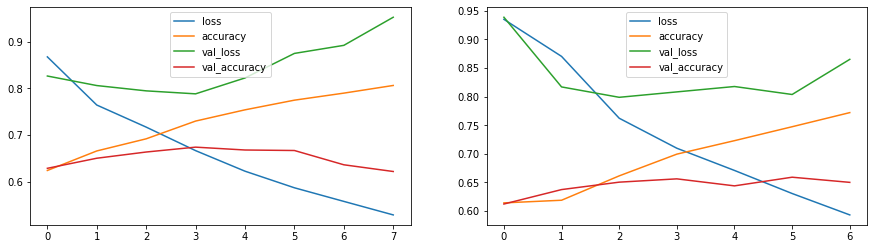

In [40]:
plot_hits(hist_lstm_2nd,hist_gru_2nd)

The model still overfit. The next improvement I will try to do is add a dropout layer.

In [42]:
lstm_pred_train=model_lstm_2nd.predict(X_train)
lstm_pred_test=model_lstm_2nd.predict(X_test)
lstm_pred_train_lbl=lstm_pred_train.argmax(axis=1)
lstm_pred_test_lbl=lstm_pred_test.argmax(axis=1)
print(classification_report(y_train, lstm_pred_train_lbl))
print(classification_report(y_test, lstm_pred_test_lbl))

              precision    recall  f1-score   support

           0       0.77      0.96      0.85      5449
           1       0.75      0.44      0.55      2004
           2       0.75      0.48      0.59      1417

    accuracy                           0.76      8870
   macro avg       0.76      0.63      0.66      8870
weighted avg       0.76      0.76      0.74      8870

              precision    recall  f1-score   support

           0       0.72      0.89      0.79      1698
           1       0.53      0.31      0.39       628
           2       0.55      0.39      0.46       447

    accuracy                           0.67      2773
   macro avg       0.60      0.53      0.55      2773
weighted avg       0.65      0.67      0.65      2773



In [43]:
gru_pred_train=model_gru_2nd.predict(X_train)
gru_pred_test=model_gru_2nd.predict(X_test)
gru_pred_train_lbl=gru_pred_train.argmax(axis=1)
gru_pred_test_lbl=gru_pred_test.argmax(axis=1)
print(classification_report(y_train, gru_pred_train_lbl))
print(classification_report(y_test, gru_pred_test_lbl))

              precision    recall  f1-score   support

           0       0.74      0.94      0.83      5449
           1       0.51      0.28      0.36      2004
           2       0.67      0.39      0.49      1417

    accuracy                           0.70      8870
   macro avg       0.64      0.54      0.56      8870
weighted avg       0.68      0.70      0.67      8870

              precision    recall  f1-score   support

           0       0.71      0.89      0.79      1698
           1       0.38      0.23      0.28       628
           2       0.59      0.34      0.43       447

    accuracy                           0.65      2773
   macro avg       0.56      0.48      0.50      2773
weighted avg       0.61      0.65      0.62      2773



As indicated in the tracking plot, the model is an overfit model, but the training process does not reach the end of the epoch because when the model is fit a call back has been made which will stop the training process if the model does not improve by 4 epochs. The difference in accuracy is 5% in the GR model, and the difference is 9% in the LSTM model.

## Menambahkan Drop Out

I added a Drop out layer to reduce overfit. The way dropout works is to turn off some neurons that are deemed unnecessary during the training process

In [44]:
model_lstm_3rd = Sequential()
model_lstm_3rd.add(text_vectorization)
model_lstm_3rd.add(Embedding(input_dim=jml_vocab,
                      output_dim=50,
                      embeddings_initializer="uniform",
                      input_length=jml_vocab
                      ))
model_lstm_3rd.add(SpatialDropout1D(0.3))
model_lstm_3rd.add(LSTM(max_feature, return_sequences=True))
model_lstm_3rd.add(LSTM(64))
model_lstm_3rd.add(Dense(3,activation='softmax'))

model_lstm_3rd.compile(loss = 'categorical_crossentropy', optimizer='RMSprop',metrics = ['accuracy'])
print(model_lstm_3rd.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 32)               0         
 torization)                                                     
                                                                 
 embedding_3 (Embedding)     (None, 32, 50)            456500    
                                                                 
 spatial_dropout1d (SpatialD  (None, 32, 50)           0         
 ropout1D)                                                       
                                                                 
 lstm_2 (LSTM)               (None, 32, 32)            10624     
                                                                 
 lstm_3 (LSTM)               (None, 64)                24832     
                                                                 
 dense_3 (Dense)             (None, 3)                

In [98]:
model_gru_3rd = Sequential()
model_gru_3rd.add(text_vectorization)
model_gru_3rd.add(Embedding(input_dim=jml_vocab,
                      output_dim=50,
                      embeddings_initializer="uniform",
                      input_length=jml_vocab
                      ))
model_gru_3rd.add(SpatialDropout1D(0.3))
model_gru_3rd.add(GRU(max_feature, return_sequences=True))
model_gru_3rd.add(GRU(64))
model_gru_3rd.add(Dense(3,activation='softmax'))

model_gru_3rd.compile(loss = 'categorical_crossentropy', optimizer='RMSprop',metrics = ['accuracy'])
print(model_gru_3rd.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 32)               0         
 torization)                                                     
                                                                 
 embedding_6 (Embedding)     (None, 32, 50)            456500    
                                                                 
 spatial_dropout1d_6 (Spatia  (None, 32, 50)           0         
 lDropout1D)                                                     
                                                                 
 gru_6 (GRU)                 (None, 32, 32)            8064      
                                                                 
 gru_7 (GRU)                 (None, 64)                18816     
                                                                 
 dense_10 (Dense)            (None, 3)                

In [46]:
csv_logger = CSVLogger('hist_lstm_3rd.log')
model_checkpoint_callback = ModelCheckpoint(
    filepath='model/lstm_3rd',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

hist_lstm_3rd = model_lstm_3rd.fit(X_train,
                         y_train_ohe,
                         epochs=50,
                         batch_size=16,
                         callbacks=[cb,csv_logger, model_checkpoint_callback],
                         validation_data=(X_test, y_test_ohe))

Epoch 1/50
555/555 [==============================] - 11s 14ms/step - loss: 0.8904 - accuracy: 0.6218 - val_loss: 0.8459 - val_accuracy: 0.6289
Epoch 2/50
555/555 [==============================] - 6s 11ms/step - loss: 0.7904 - accuracy: 0.6524 - val_loss: 0.8089 - val_accuracy: 0.6516
Epoch 3/50
555/555 [==============================] - 6s 10ms/step - loss: 0.7485 - accuracy: 0.6785 - val_loss: 0.8171 - val_accuracy: 0.6415
Epoch 4/50
555/555 [==============================] - 6s 11ms/step - loss: 0.7165 - accuracy: 0.6928 - val_loss: 0.8022 - val_accuracy: 0.6387
Epoch 5/50
555/555 [==============================] - 9s 16ms/step - loss: 0.6905 - accuracy: 0.7126 - val_loss: 0.8005 - val_accuracy: 0.6617
Epoch 6/50
555/555 [==============================] - 9s 17ms/step - loss: 0.6622 - accuracy: 0.7308 - val_loss: 0.8224 - val_accuracy: 0.6473
Epoch 7/50
555/555 [==============================] - 9s 16ms/step - loss: 0.6355 - accuracy: 0.7480 - val_loss: 0.8378 - val_accuracy: 0.659

In [99]:
csv_logger = CSVLogger('hist_gru_3rd.log')
model_checkpoint_callback = ModelCheckpoint(
    filepath='model/gru_3rd',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

hist_gru_3rd = model_gru_3rd.fit(X_train,
                         y_train_ohe,
                         epochs=50,
                         batch_size=16,
                         callbacks=[cb,csv_logger, model_checkpoint_callback],
                         validation_data=(X_test, y_test_ohe))

Epoch 1/50
555/555 [==============================] - 10s 12ms/step - loss: 0.9359 - accuracy: 0.6136 - val_loss: 0.9342 - val_accuracy: 0.6123
Epoch 2/50
555/555 [==============================] - 6s 11ms/step - loss: 0.8576 - accuracy: 0.6255 - val_loss: 0.8197 - val_accuracy: 0.6412
Epoch 3/50
555/555 [==============================] - 7s 12ms/step - loss: 0.7706 - accuracy: 0.6653 - val_loss: 0.8092 - val_accuracy: 0.6358
Epoch 4/50
555/555 [==============================] - 8s 14ms/step - loss: 0.7298 - accuracy: 0.6874 - val_loss: 0.8117 - val_accuracy: 0.6574
Epoch 5/50
555/555 [==============================] - 9s 17ms/step - loss: 0.6946 - accuracy: 0.7090 - val_loss: 0.8202 - val_accuracy: 0.6246
Epoch 6/50
555/555 [==============================] - 10s 17ms/step - loss: 0.6631 - accuracy: 0.7300 - val_loss: 0.7936 - val_accuracy: 0.6628
Epoch 7/50
555/555 [==============================] - 10s 18ms/step - loss: 0.6354 - accuracy: 0.7471 - val_loss: 0.8096 - val_accuracy: 0.6

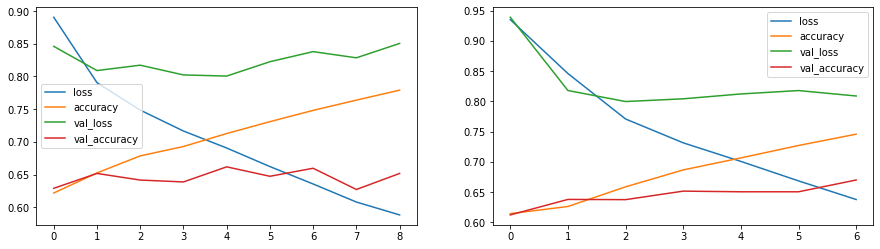

In [48]:
plot_hits(hist_lstm_3rd,hist_gru_3rd)

Adding drop outs cannot fix the overfit issue in the model. The model still experiences overfit. The model stops training at epoch 8 for the lstm model and epoch 6 for the GRU model.

In [49]:
lstm_pred_train=model_lstm_3rd.predict(X_train)
lstm_pred_test=model_lstm_3rd.predict(X_test)
lstm_pred_train_lbl=lstm_pred_train.argmax(axis=1)
lstm_pred_test_lbl=lstm_pred_test.argmax(axis=1)
print(classification_report(y_train, lstm_pred_train_lbl))
print(classification_report(y_test, lstm_pred_test_lbl))

              precision    recall  f1-score   support

           0       0.79      0.92      0.85      5449
           1       0.59      0.44      0.51      2004
           2       0.71      0.50      0.59      1417

    accuracy                           0.75      8870
   macro avg       0.70      0.62      0.65      8870
weighted avg       0.73      0.75      0.73      8870

              precision    recall  f1-score   support

           0       0.73      0.85      0.79      1698
           1       0.44      0.35      0.39       628
           2       0.57      0.40      0.47       447

    accuracy                           0.66      2773
   macro avg       0.58      0.53      0.55      2773
weighted avg       0.64      0.66      0.64      2773



In [50]:
gru_pred_train=model_gru_3rd.predict(X_train)
gru_pred_test=model_gru_3rd.predict(X_test)
gru_pred_train_lbl=gru_pred_train.argmax(axis=1)
gru_pred_test_lbl=gru_pred_test.argmax(axis=1)
print(classification_report(y_train, gru_pred_train_lbl))
print(classification_report(y_test, gru_pred_test_lbl))

              precision    recall  f1-score   support

           0       0.70      0.96      0.81      5449
           1       0.38      0.19      0.25      2004
           2       0.80      0.21      0.33      1417

    accuracy                           0.67      8870
   macro avg       0.63      0.45      0.46      8870
weighted avg       0.64      0.67      0.61      8870

              precision    recall  f1-score   support

           0       0.67      0.95      0.79      1698
           1       0.30      0.12      0.17       628
           2       0.69      0.17      0.28       447

    accuracy                           0.64      2773
   macro avg       0.55      0.42      0.41      2773
weighted avg       0.59      0.64      0.57      2773



Adding dropouts also still cannot solve the overfit problem in the model. The difference in accuracy in the LTSM model is 9% (75% accuracy train, 66% accuracy data test) while in the group it is 3% (67% accuracy train, 63% accuracy data test)

## Tambah Hiden Layer

In the 3rd improvement experiment I tried to add 1 more hidden layer to improve model performance.

In [92]:
model_lstm_4th = Sequential()
model_lstm_4th.add(text_vectorization)
model_lstm_4th.add(Embedding(input_dim=jml_vocab,
                      output_dim=50,
                      embeddings_initializer="uniform",
                      input_length=jml_vocab
                      ))
model_lstm_4th.add(SpatialDropout1D(0.3))
model_lstm_4th.add(LSTM(max_feature, return_sequences=True))
model_lstm_4th.add(LSTM(64))

model_lstm_4th.add(Dense(40,activation='relu'))
model_lstm_4th.add(Dense(3,activation='softmax'))

model_lstm_4th.compile(loss = 'categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.1),metrics = ['accuracy'])
print(model_lstm_4th.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 32)               0         
 torization)                                                     
                                                                 
 embedding_4 (Embedding)     (None, 32, 50)            456500    
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 32, 50)           0         
 lDropout1D)                                                     
                                                                 
 lstm_4 (LSTM)               (None, 32, 32)            10624     
                                                                 
 lstm_5 (LSTM)               (None, 64)                24832     
                                                                 
 dense_7 (Dense)             (None, 40)               

In [64]:
model_gru_4th = Sequential()
model_gru_4th.add(text_vectorization)
model_gru_4th.add(Embedding(input_dim=jml_vocab,
                      output_dim=50,
                      embeddings_initializer="uniform",
                      input_length=jml_vocab
                      ))
model_gru_4th.add(SpatialDropout1D(0.3))
model_gru_4th.add(GRU(max_feature, return_sequences=True))
model_gru_4th.add(GRU(64))
model_gru_4th.add(Dense(3,activation='softmax'))

model_gru_4th.compile(loss = 'categorical_crossentropy', optimizer='RMSprop',metrics = ['accuracy'])
print(model_gru_4th.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 32)               0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 32, 50)            456500    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 32, 50)           0         
 lDropout1D)                                                     
                                                                 
 gru (GRU)                   (None, 32, 32)            8064      
                                                                 
 gru_1 (GRU)                 (None, 64)                18816     
                                                                 
 dense_2 (Dense)             (None, 3)                

In [93]:
csv_logger = CSVLogger('hist_lstm_4th.log')
model_checkpoint_callback = ModelCheckpoint(
    filepath='model/lstm_4th',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

hist_lstm_4th = model_lstm_4th.fit(X_train,
                         y_train_ohe,
                         epochs=50,
                         batch_size=32,
                         callbacks=[cb,csv_logger, model_checkpoint_callback],
                         validation_data=(X_test, y_test_ohe))

Epoch 1/50
278/278 [==============================] - 7s 15ms/step - loss: 1.0333 - accuracy: 0.6046 - val_loss: 0.9358 - val_accuracy: 0.6123
Epoch 2/50
278/278 [==============================] - 3s 12ms/step - loss: 0.9345 - accuracy: 0.6143 - val_loss: 0.9452 - val_accuracy: 0.6123
Epoch 3/50
278/278 [==============================] - 3s 11ms/step - loss: 0.9349 - accuracy: 0.6143 - val_loss: 0.9362 - val_accuracy: 0.6123
Epoch 4/50
278/278 [==============================] - 3s 11ms/step - loss: 0.9334 - accuracy: 0.6143 - val_loss: 0.9416 - val_accuracy: 0.6123
Epoch 5/50
278/278 [==============================] - 3s 12ms/step - loss: 0.9355 - accuracy: 0.6143 - val_loss: 0.9403 - val_accuracy: 0.6123


In [65]:
csv_logger = CSVLogger('hist_gru_4th.log')
model_checkpoint_callback = ModelCheckpoint(
    filepath='model/gru_4th',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


hist_gru_4th = model_gru_4th.fit(X_train,
                         y_train_ohe,
                         epochs=50,
                         batch_size=16,
                         callbacks=[cb,csv_logger, model_checkpoint_callback],
                         validation_data=(X_test, y_test_ohe))

Epoch 1/50
555/555 [==============================] - 9s 11ms/step - loss: 0.9346 - accuracy: 0.6135 - val_loss: 0.9415 - val_accuracy: 0.6123
Epoch 2/50
555/555 [==============================] - 5s 10ms/step - loss: 0.9052 - accuracy: 0.6132 - val_loss: 0.8482 - val_accuracy: 0.6250
Epoch 3/50
555/555 [==============================] - 6s 12ms/step - loss: 0.7972 - accuracy: 0.6476 - val_loss: 0.8378 - val_accuracy: 0.6120
Epoch 4/50
555/555 [==============================] - 8s 14ms/step - loss: 0.7474 - accuracy: 0.6788 - val_loss: 0.8028 - val_accuracy: 0.6426
Epoch 5/50
555/555 [==============================] - 8s 14ms/step - loss: 0.7111 - accuracy: 0.6958 - val_loss: 0.8044 - val_accuracy: 0.6488
Epoch 6/50
555/555 [==============================] - 9s 16ms/step - loss: 0.6795 - accuracy: 0.7180 - val_loss: 0.8052 - val_accuracy: 0.6513
Epoch 7/50
555/555 [==============================] - 8s 14ms/step - loss: 0.6485 - accuracy: 0.7380 - val_loss: 0.8214 - val_accuracy: 0.6563

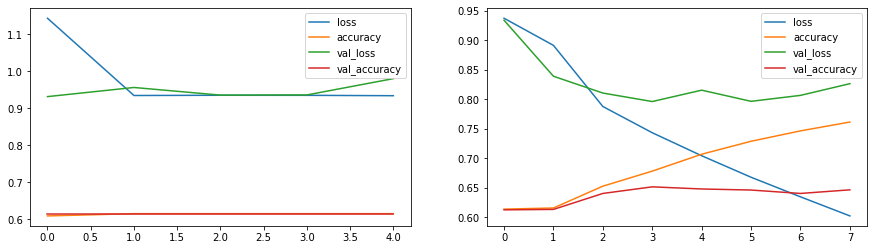

In [55]:
plot_hits(hist_lstm_4th,hist_gru_4th)

The resulting model is still an overfit model. Even the LTSM model stops at epoch 4, which means the model has not experienced an increase in performance since the second epoch. while the fourth GRU model is also an overfit model with the training process reaching the 7th epoch.

In [94]:
lstm_pred_train=model_lstm_4th.predict(X_train)
lstm_pred_test=model_lstm_4th.predict(X_test)
lstm_pred_train_lbl=lstm_pred_train.argmax(axis=1)
lstm_pred_test_lbl=lstm_pred_test.argmax(axis=1)
print(classification_report(y_train, lstm_pred_train_lbl))
print(classification_report(y_test, lstm_pred_test_lbl))

              precision    recall  f1-score   support

           0       0.61      1.00      0.76      5449
           1       0.00      0.00      0.00      2004
           2       0.00      0.00      0.00      1417

    accuracy                           0.61      8870
   macro avg       0.20      0.33      0.25      8870
weighted avg       0.38      0.61      0.47      8870

              precision    recall  f1-score   support

           0       0.61      1.00      0.76      1698
           1       0.00      0.00      0.00       628
           2       0.00      0.00      0.00       447

    accuracy                           0.61      2773
   macro avg       0.20      0.33      0.25      2773
weighted avg       0.37      0.61      0.47      2773



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [67]:
gru_pred_train=model_gru_4th.predict(X_train)
gru_pred_test=model_gru_4th.predict(X_test)
gru_pred_train_lbl=gru_pred_train.argmax(axis=1)
gru_pred_test_lbl=gru_pred_test.argmax(axis=1)
print(classification_report(y_train, gru_pred_train_lbl))
print(classification_report(y_test, gru_pred_test_lbl))

              precision    recall  f1-score   support

           0       0.79      0.88      0.83      5449
           1       0.49      0.46      0.47      2004
           2       0.64      0.41      0.50      1417

    accuracy                           0.71      8870
   macro avg       0.64      0.58      0.60      8870
weighted avg       0.70      0.71      0.70      8870

              precision    recall  f1-score   support

           0       0.74      0.82      0.78      1698
           1       0.39      0.39      0.39       628
           2       0.56      0.34      0.42       447

    accuracy                           0.64      2773
   macro avg       0.56      0.51      0.53      2773
weighted avg       0.63      0.64      0.63      2773



The fourth LSTM model is the worst model and even has an undefined precision score. Meanwhile, the 4th GRU model is an overfit model with an accuracy difference of 7% (71% accuracy on train data, 64% on test data).

## Pretained Embeding

The final improvement I did was to use pretrained embossing of the glove. This data contains word embedding data taken from 27 billion tweets containing 1.2 billion vocabularies and their vectors. The vector of the glove has dimension 50. Next, the glove embedding data is sorted according to the vocab data in the data train.

In [ ]:
#download glove twitter
# ! wget https://nlp.stanford.edu/data/glove.twitter.27B.zip
# ! unzip glove*.zip

In [58]:
# extract from txt to dictionary
path_to_glove_file = "glove.twitter.27B.50d.txt"
embeddings_dict = {}
with open(path_to_glove_file) as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector


In [59]:
# adjust the vocab according to the vocab in the train data
miss=0
miss_vocab=[]
i=0
pretrained_embeding = np.zeros((len(Vectorize.vocabulary_.keys()), 50))
for word in Vectorize.vocabulary_.keys():
  embeding_vector=embeddings_dict.get(word)
  if embeding_vector is not None: # if there is vocab there is a glove
    pretrained_embeding[i]=embeding_vector # simpan vector
  else: # If not
    pretrained_embeding[i]=np.zeros(50) # fill it with an empty vector
    miss+=1
    miss_vocab.append(word) # save the vocab that is not on the glove
  i+=1

In [ ]:
miss

960

In [60]:
tf.keras.backend.clear_session()

In [61]:
tf_idf_process=make_pipeline(CountVectorizer(), TfidfTransformer())
X_train_tfidf = tf_idf_process.fit_transform(X_train)
X_test_tfidf = tf_idf_process.transform(X_test)
X_val_tfidf = tf_idf_process.transform(X_val)

In [68]:
embedding = Embedding(input_dim=jml_vocab,
                      output_dim=50,
                      input_length=jml_vocab,
                      embeddings_initializer=tf.keras.initializers.Constant(pretrained_embeding),
                      trainable=False
                      )
model_lstm_5th = Sequential()
model_lstm_5th.add(embedding)
model_lstm_5th.add(SpatialDropout1D(0.3))
model_lstm_5th.add(LSTM(max_feature, return_sequences=True))
model_lstm_5th.add(LSTM(40))
model_lstm_5th.add(Dense(32,activation='elu'))
model_lstm_5th.add(Dense(3,activation='softmax'))
model_lstm_5th.compile(loss = 'categorical_crossentropy', optimizer='RMSprop',metrics = ['accuracy'])
print(model_lstm_5th.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 9130, 50)          456500    
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 9130, 50)         0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 9130, 32)          10624     
                                                                 
 lstm_3 (LSTM)               (None, 40)                11680     
                                                                 
 dense_3 (Dense)             (None, 32)                1312      
                                                                 
 dense_4 (Dense)             (None, 3)                 99        
                                                      

In [69]:
csv_logger = CSVLogger('hist_lstm_5th.log')
model_checkpoint_callback = ModelCheckpoint(
    filepath='model/lstm_5th',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
hist_lstm_5th = model_lstm_5th.fit(X_train_tfidf.todense(),
                         y_train_ohe,
                         epochs=50,
                         batch_size=64,
                         callbacks=[cb,csv_logger, model_checkpoint_callback],
                         validation_data=(X_test_tfidf.todense(), y_test_ohe))

Epoch 1/50
139/139 [==============================] - 81s 559ms/step - loss: 0.9368 - accuracy: 0.6109 - val_loss: 0.9416 - val_accuracy: 0.6123
Epoch 2/50
139/139 [==============================] - 80s 574ms/step - loss: 0.9318 - accuracy: 0.6143 - val_loss: 0.9332 - val_accuracy: 0.6123
Epoch 3/50
139/139 [==============================] - 74s 530ms/step - loss: 0.9309 - accuracy: 0.6143 - val_loss: 0.9364 - val_accuracy: 0.6123
Epoch 4/50
139/139 [==============================] - 74s 531ms/step - loss: 0.9303 - accuracy: 0.6143 - val_loss: 0.9360 - val_accuracy: 0.6123
Epoch 5/50
139/139 [==============================] - 75s 539ms/step - loss: 0.9306 - accuracy: 0.6143 - val_loss: 0.9318 - val_accuracy: 0.6123
Epoch 6/50
139/139 [==============================] - 76s 548ms/step - loss: 0.9294 - accuracy: 0.6143 - val_loss: 0.9329 - val_accuracy: 0.6123
Epoch 7/50
139/139 [==============================] - 74s 532ms/step - loss: 0.9300 - accuracy: 0.6143 - val_loss: 0.9310 - val_ac

In [70]:
model_gru_5th = Sequential()
model_gru_5th.add(Embedding(input_dim=jml_vocab,
                      output_dim=50,
                      input_length=jml_vocab,
                      embeddings_initializer=tf.keras.initializers.Constant(pretrained_embeding),
                      trainable=False
                      ))
model_gru_5th.add(SpatialDropout1D(0.3))
model_gru_5th.add(GRU(max_feature, return_sequences=True))
model_gru_5th.add(GRU(40))
model_gru_5th.add(Dense(32,activation='elu'))
model_gru_5th.add(Dense(3,activation='softmax'))
model_gru_5th.compile(loss = 'categorical_crossentropy', optimizer='RMSprop',metrics = ['accuracy'])
print(model_gru_5th.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 9130, 50)          456500    
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 9130, 50)         0         
 lDropout1D)                                                     
                                                                 
 gru_2 (GRU)                 (None, 9130, 32)          8064      
                                                                 
 gru_3 (GRU)                 (None, 40)                8880      
                                                                 
 dense_5 (Dense)             (None, 32)                1312      
                                                                 
 dense_6 (Dense)             (None, 3)                 99        
                                                      

In [ ]:
tf.keras.backend.clear_session()

In [71]:
csv_logger = CSVLogger('hist_gru_5th.log')
model_checkpoint_callback = ModelCheckpoint(
    filepath='model/gru_5th',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

hist_gru_5th = model_gru_5th.fit(X_train_tfidf.todense(),
                         y_train_ohe,
                         epochs=50,
                         batch_size=64,
                         callbacks=[cb,csv_logger, model_checkpoint_callback],
                         validation_data=(X_test_tfidf.todense(), y_test_ohe))

Epoch 1/50
139/139 [==============================] - 77s 535ms/step - loss: 0.9378 - accuracy: 0.6107 - val_loss: 0.9320 - val_accuracy: 0.6123
Epoch 2/50
139/139 [==============================] - 77s 556ms/step - loss: 0.9346 - accuracy: 0.6143 - val_loss: 0.9423 - val_accuracy: 0.6123
Epoch 3/50
139/139 [==============================] - 100s 719ms/step - loss: 0.9337 - accuracy: 0.6143 - val_loss: 0.9318 - val_accuracy: 0.6123
Epoch 4/50
139/139 [==============================] - 74s 535ms/step - loss: 0.9328 - accuracy: 0.6143 - val_loss: 0.9366 - val_accuracy: 0.6123
Epoch 5/50
139/139 [==============================] - 74s 531ms/step - loss: 0.9323 - accuracy: 0.6143 - val_loss: 0.9332 - val_accuracy: 0.6123
Epoch 6/50
139/139 [==============================] - 74s 534ms/step - loss: 0.9324 - accuracy: 0.6143 - val_loss: 0.9312 - val_accuracy: 0.6123
Epoch 7/50
139/139 [==============================] - 74s 531ms/step - loss: 0.9310 - accuracy: 0.6143 - val_loss: 0.9317 - val_a

In [ ]:
csv_logger = CSVLogger('hist_gru_5th.log')
model_checkpoint_callback = ModelCheckpoint(
    filepath='model/gru_5th',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

hist_gru_5th = model_gru_5th.fit(X_train_tfidf.todense(),
                         y_train_ohe,
                         epochs=50,
                         batch_size=64,
                         callbacks=[cb,csv_logger, model_checkpoint_callback],
                         validation_data=(X_test_tfidf.todense(), y_test_ohe))

Epoch 1/50
138/138 [==============================] - 79s 549ms/step - loss: 0.9451 - accuracy: 0.6079 - val_loss: 0.9330 - val_accuracy: 0.6123
Epoch 2/50
138/138 [==============================] - 79s 573ms/step - loss: 0.9395 - accuracy: 0.6079 - val_loss: 0.9310 - val_accuracy: 0.6123
Epoch 3/50
138/138 [==============================] - 74s 536ms/step - loss: 0.9385 - accuracy: 0.6079 - val_loss: 0.9326 - val_accuracy: 0.6123
Epoch 4/50
138/138 [==============================] - 74s 535ms/step - loss: 0.9380 - accuracy: 0.6079 - val_loss: 0.9311 - val_accuracy: 0.6123
Epoch 5/50
138/138 [==============================] - 74s 536ms/step - loss: 0.9382 - accuracy: 0.6079 - val_loss: 0.9316 - val_accuracy: 0.6123
Epoch 6/50
138/138 [==============================] - 74s 538ms/step - loss: 0.9381 - accuracy: 0.6079 - val_loss: 0.9309 - val_accuracy: 0.6123
Epoch 7/50
138/138 [==============================] - 74s 535ms/step - loss: 0.9370 - accuracy: 0.6079 - val_loss: 0.9353 - val_ac

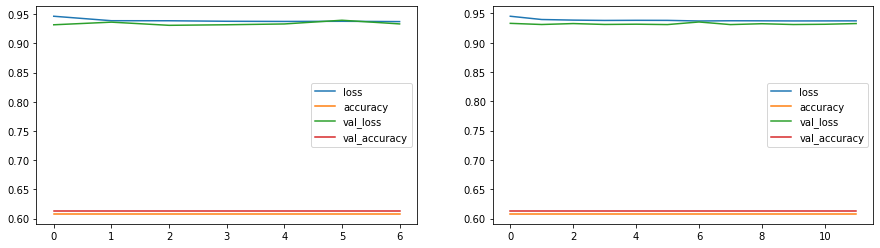

In [ ]:
plot_hits(hist_lstm_4th,hist_gru_4th)

The model is indicated to experience a gradient vanish problem. This can be concluded from the stagnant accuracy values ​​in the train data and validation data. This may be due to the large number of cocab misses, amounting to 960 or around 10% of the total vocabulary.

In [ ]:
lstm_pred_train=model_lstm_5th.predict(X_train)
lstm_pred_test=model_lstm_5th.predict(X_test)
lstm_pred_train_lbl=lstm_pred_train.argmax(axis=1)
lstm_pred_test_lbl=lstm_pred_test.argmax(axis=1)
print(classification_report(y_train, lstm_pred_train_lbl))
print(classification_report(y_test, lstm_pred_test_lbl))

              precision    recall  f1-score   support

           0       0.61      1.00      0.76      5449
           1       0.00      0.00      0.00      2004
           2       0.00      0.00      0.00      1417

    accuracy                           0.61      8870
   macro avg       0.20      0.33      0.25      8870
weighted avg       0.38      0.61      0.47      8870

              precision    recall  f1-score   support

           0       0.61      1.00      0.76      1698
           1       0.00      0.00      0.00       628
           2       0.00      0.00      0.00       447

    accuracy                           0.61      2773
   macro avg       0.20      0.33      0.25      2773
weighted avg       0.37      0.61      0.47      2773



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [ ]:
gru_pred_train=model_gru_5th.predict(X_train)
gru_pred_test=model_gru_5th.predict(X_test)
gru_pred_train_lbl=gru_pred_train.argmax(axis=1)
gru_pred_test_lbl=gru_pred_test.argmax(axis=1)
print(classification_report(y_train, gru_pred_train_lbl))
print(classification_report(y_test, gru_pred_test_lbl))

              precision    recall  f1-score   support

           0       0.79      0.88      0.83      5449
           1       0.49      0.46      0.47      2004
           2       0.64      0.41      0.50      1417

    accuracy                           0.71      8870
   macro avg       0.64      0.58      0.60      8870
weighted avg       0.70      0.71      0.70      8870

              precision    recall  f1-score   support

           0       0.74      0.82      0.78      1698
           1       0.39      0.39      0.39       628
           2       0.56      0.34      0.42       447

    accuracy                           0.64      2773
   macro avg       0.56      0.51      0.53      2773
weighted avg       0.63      0.64      0.63      2773



Setelah dilakukan improvement ke 4 model masih juga mengalami overfit. Pada model LSTM ke 5 precisision dan recall class 1 dan 2 tidak terefinisi.

# Inferencing

Because all the data is overfit and has a low accuracy score, I will use the model with the smallest difference in accuracy scores, namely the group 3 model which has a difference in accuracy scores of 3%.

In [ ]:
model_gru_3rd.trainable=False
model_gru_3rd.save('gru_3rd')

In [101]:
data_inf['feature']=data_inf['text'].apply(lambda x: preprocessing_text(x))
data_inf['feature']

2134     chrischristie blasts sanctuary cities finds fo...
1654     even media n't get one last night 's men alien...
9138     american people pick next president united sta...
10561    purpose military kill people break things kkko...
2919     maybe right try amp destroy obama st term 's h...
654      candidates deleted subpoenaed emails readyforh...
4872     'm trying answer accusation sexism megyn stop ...
4842                                   welcome thunderdome
1751                         honestly really want hear say
11494    hey wallace guys better plan president obama m...
Name: feature, dtype: object

In [108]:
inf_pred=model_gru_3rd.predict(data_inf['feature'])
inf_pred=inf_pred.argmax(axis=1)
data_inf['predict sentiment']=inf_pred
data_inf['predict sentiment']=data_inf['predict sentiment'].replace({0:'Negative', 1:'Neutral', 2:'Positive'})
data_inf[['text','sentiment','predict sentiment']]
# data['label'] = data['sentiment'].replace({'Negative' : 0, 'Neutral' : 1, 'Positive' : 2})

,text,sentiment,predict sentiment
2134,RT @NoChristie16: #ChrisChristie blasts sanctu...,Negative,Neutral
1654,"Even the media doesn't get it, No one won las...",Positive,Negative
9138,RT @RWSurferGirl: We the American people pick ...,Negative,Negative
10561,"RT @jamiaw: ""The purpose of the military is to...",Negative,Negative
2919,#GOPDebate Maybe they were right to try &amp; ...,Negative,Negative
654,RT @RepublicanPunk: GOP has 0 candidates who d...,Negative,Negative
4872,"RT @mikepolkjr: ""I'm trying to answer your acc...",Negative,Negative
4842,RT @MichaelLucchese: Welcome to the #Thunderdo...,Neutral,Neutral
1751,I honestly really want to hear what Ben Carson...,Neutral,Negative
11494,"RT @SupermanHotMale: Hey Chris Wallace, These ...",Negative,Negative


From ten inference data. The model was able to correctly predict 6 text data, while the other 3 texts were wrong. the three data that were incorrectly predicted were data with all sentiments. This means that based on inference data there is no special sentiment that failed to be predicted. However, this is not an overall conclusion because inference data only uses a small amount of data. 

# Conclusion

The dataset is a collection of tweets related to the GOP 1st debate. Data was taken on the night of the debate until the next day. The dataset consists of 3 targets, negative, neutral and positive sentiment. The most target data is negative sentiment and the least is positive sentiment. There are no certain characteristics in the text data that relate to the number of words used.

The results obtained from the 4 models that were made experienced overfit even after 4 improvements were made. This can happen because the words in the data set are filled with too many unknown words. I indicated this from the miss value which reached 8000 vocabs when we tried to do pretrained embedding. The number of misses is the number of missing xtrain vocab items that are not found in the glove-twitter data. Even though the number of glove-twitter vocabs reached 1.2 million vocabs, there were still misses of around 960 vocabs out of the total. The number 960 is quite large because the number of vocab on xtrain is only around 9600 vocab. Unknown words can come from typo vocab, slang vocab, or abbreviations.

The model can still be developed by considering adding other parameters to the model. Apart from that, preprocessing still needs to be improved by handling various types of slang and informal words. By handling this we can reduce vocab variations without losing information from the data itself.